### GEODATA :  Plotting  the path of Hurricane Michael onto the US map

Download the hurricaneMichael.csv and US_states(5m).json files (https://notebooks.azure.com/priesterkc/projects/DABmaterial/tree/Lv2%20Data%20Analytics/datasets)

Using the geopandas library, turn the latitude and longitude columns into a geographical Point data type then make a geodataframe. Plot the path of Hurricane Michael onto the US map in the GeoJSON file.




## Tips

After loading the US_states(5m).json file as a geodataframe, use the following code to create a geodataframe that only contains the contiguous United States (48 states):


map48 = map_df.loc[map_df['NAME'].isin(['Alaska', 'Hawaii', 'Puerto Rico']) == False]


The longitude column data should be turned into negative values(data source listed longitude direction instead of positive/negative). Use the following code to make the data correct:

HR_df['Long'] = 0 - HR_df['Long']




In [1]:
import pandas as pd
import geopandas as gpd #used for transforming geolocation data
import matplotlib.pyplot as plt

from datetime import datetime  #to convert data to datetime that does not fall within the pandas.to_datetime function timeframe
from shapely.geometry import Point  #transform latitude/longitude to geo-coordinate data
from geopandas.tools import geocode #get the latitude/longitude for a given address
from geopandas.tools import reverse_geocode  #get the address for a location using latitude/longitude
import json

%matplotlib inline

In [2]:
#load data into dataframe
HR_df = pd.read_csv('hurricaneMichael.csv')
HR_df.head()

,AdvisoryNumber,Date,Lat,Long,Wind,Pres,Movement,Type,Name,Received,Forecaster
0,1,10/6/2018 17:00,18.0,86.6,30,1006,NW at 6 MPH (325 deg),Potential Tropical Cyclone,Fourteen,10/6/2018 16:50,Beven
1,1A,10/6/2018 20:00,18.3,86.6,30,1004,N at 6 MPH (360 deg),Potential Tropical Cyclone,Fourteen,10/6/2018 19:32,Avila
2,2,10/6/2018 23:00,18.8,86.6,30,1004,N at 7 MPH (360 deg),Potential Tropical Cyclone,Fourteen,10/6/2018 22:38,Avila
3,2A,10/7/2018 2:00,18.4,87.1,35,1004,NW at 5 MPH (320 deg),Potential Tropical Cyclone,Fourteen,10/7/2018 1:38,Berg
4,3,10/7/2018 5:00,18.6,86.9,35,1004,NNW at 3 MPH (340 deg),Tropical Depression,FOURTEEN,10/7/2018 4:53,Berg


In [3]:
HR_df['Long'] = 0 - HR_df['Long']  # The longitude column data should be turned into negative values(data source listed longitude direction instead of positive/negative)

In [4]:
HR_df.head() # First 5 rows

,AdvisoryNumber,Date,Lat,Long,Wind,Pres,Movement,Type,Name,Received,Forecaster
0,1,10/6/2018 17:00,18.0,-86.6,30,1006,NW at 6 MPH (325 deg),Potential Tropical Cyclone,Fourteen,10/6/2018 16:50,Beven
1,1A,10/6/2018 20:00,18.3,-86.6,30,1004,N at 6 MPH (360 deg),Potential Tropical Cyclone,Fourteen,10/6/2018 19:32,Avila
2,2,10/6/2018 23:00,18.8,-86.6,30,1004,N at 7 MPH (360 deg),Potential Tropical Cyclone,Fourteen,10/6/2018 22:38,Avila
3,2A,10/7/2018 2:00,18.4,-87.1,35,1004,NW at 5 MPH (320 deg),Potential Tropical Cyclone,Fourteen,10/7/2018 1:38,Berg
4,3,10/7/2018 5:00,18.6,-86.9,35,1004,NNW at 3 MPH (340 deg),Tropical Depression,FOURTEEN,10/7/2018 4:53,Berg


In [5]:
#only include rows with non-null latitudes (which means longitude is also not null) 
HR_df = HR_df.loc[(HR_df['Lat'].notnull())] 
HR_df.count()

AdvisoryNumber    45
Date              45
Lat               45
Long              45
Wind              45
Pres              45
Movement          45
Type              45
Name              45
Received          45
Forecaster        45
dtype: int64

In [6]:
#make a new column to hold the longitude & latitude as a list
HR_df['coordinates'] = list(HR_df[['Long', 'Lat']].values)

In [7]:
#see new coordinates column
HR_df.head()

,AdvisoryNumber,Date,Lat,Long,Wind,Pres,Movement,Type,Name,Received,Forecaster,coordinates
0,1,10/6/2018 17:00,18.0,-86.6,30,1006,NW at 6 MPH (325 deg),Potential Tropical Cyclone,Fourteen,10/6/2018 16:50,Beven,"[-86.6, 18.0]"
1,1A,10/6/2018 20:00,18.3,-86.6,30,1004,N at 6 MPH (360 deg),Potential Tropical Cyclone,Fourteen,10/6/2018 19:32,Avila,"[-86.6, 18.3]"
2,2,10/6/2018 23:00,18.8,-86.6,30,1004,N at 7 MPH (360 deg),Potential Tropical Cyclone,Fourteen,10/6/2018 22:38,Avila,"[-86.6, 18.8]"
3,2A,10/7/2018 2:00,18.4,-87.1,35,1004,NW at 5 MPH (320 deg),Potential Tropical Cyclone,Fourteen,10/7/2018 1:38,Berg,"[-87.1, 18.4]"
4,3,10/7/2018 5:00,18.6,-86.9,35,1004,NNW at 3 MPH (340 deg),Tropical Depression,FOURTEEN,10/7/2018 4:53,Berg,"[-86.9, 18.6]"


In [8]:
#list values in coordinates column is classified as object type
HR_df['coordinates'].dtypes

dtype('O')

In [9]:
#convert the coordinates to a geolocation type
HR_df['coordinates'] = HR_df['coordinates'].apply(Point)

In [10]:
#coordinates column now has POINT next to each coordinate pair value
HR_df.head()

,AdvisoryNumber,Date,Lat,Long,Wind,Pres,Movement,Type,Name,Received,Forecaster,coordinates
0,1,10/6/2018 17:00,18.0,-86.6,30,1006,NW at 6 MPH (325 deg),Potential Tropical Cyclone,Fourteen,10/6/2018 16:50,Beven,POINT (-86.59999999999999 18)
1,1A,10/6/2018 20:00,18.3,-86.6,30,1004,N at 6 MPH (360 deg),Potential Tropical Cyclone,Fourteen,10/6/2018 19:32,Avila,POINT (-86.59999999999999 18.3)
2,2,10/6/2018 23:00,18.8,-86.6,30,1004,N at 7 MPH (360 deg),Potential Tropical Cyclone,Fourteen,10/6/2018 22:38,Avila,POINT (-86.59999999999999 18.8)
3,2A,10/7/2018 2:00,18.4,-87.1,35,1004,NW at 5 MPH (320 deg),Potential Tropical Cyclone,Fourteen,10/7/2018 1:38,Berg,POINT (-87.09999999999999 18.4)
4,3,10/7/2018 5:00,18.6,-86.9,35,1004,NNW at 3 MPH (340 deg),Tropical Depression,FOURTEEN,10/7/2018 4:53,Berg,POINT (-86.90000000000001 18.6)


In [11]:
#coordinates column with geolocation data is just a regular pandas Series type
type(HR_df['coordinates'])

pandas.core.series.Series

In [12]:
#create a geolocation dataframe type using the coordinates column as the geolocation data
geo_HR = gpd.GeoDataFrame(HR_df, geometry='coordinates')

In [13]:
#geo-dataframe looks the same as regular dataframe
geo_HR.head()

,AdvisoryNumber,Date,Lat,Long,Wind,Pres,Movement,Type,Name,Received,Forecaster,coordinates
0,1,10/6/2018 17:00,18.0,-86.6,30,1006,NW at 6 MPH (325 deg),Potential Tropical Cyclone,Fourteen,10/6/2018 16:50,Beven,POINT (-86.59999999999999 18)
1,1A,10/6/2018 20:00,18.3,-86.6,30,1004,N at 6 MPH (360 deg),Potential Tropical Cyclone,Fourteen,10/6/2018 19:32,Avila,POINT (-86.59999999999999 18.3)
2,2,10/6/2018 23:00,18.8,-86.6,30,1004,N at 7 MPH (360 deg),Potential Tropical Cyclone,Fourteen,10/6/2018 22:38,Avila,POINT (-86.59999999999999 18.8)
3,2A,10/7/2018 2:00,18.4,-87.1,35,1004,NW at 5 MPH (320 deg),Potential Tropical Cyclone,Fourteen,10/7/2018 1:38,Berg,POINT (-87.09999999999999 18.4)
4,3,10/7/2018 5:00,18.6,-86.9,35,1004,NNW at 3 MPH (340 deg),Tropical Depression,FOURTEEN,10/7/2018 4:53,Berg,POINT (-86.90000000000001 18.6)


In [14]:
#verify coordinates column is geolocation data type
type(geo_HR['coordinates'])

geopandas.geoseries.GeoSeries

#import file that contains a US map shape polygons

In [15]:
#import file that contains a world map shape polygons
#will use to plot the coordinates of meteorite landings
filepath = "US_states.json"

#data contains polygon shape coordinates for different map body types (continents, etc.)
map_df = gpd.read_file(filepath)
map_df.head()

,GEO_ID,STATE,NAME,LSAD,CENSUSAREA,geometry
0,0400000US01,01,Alabama,,50645.326,"(POLYGON ((-88.124658 30.28364, -88.0868119999..."
1,0400000US02,02,Alaska,,570640.950,"(POLYGON ((-166.10574 53.988606, -166.075283 5..."
2,0400000US04,04,Arizona,,113594.084,"POLYGON ((-112.538593 37.000674, -112.534545 3..."
3,0400000US05,05,Arkansas,,52035.477,"POLYGON ((-94.042964 33.019219, -94.043036 33...."
4,0400000US06,06,California,,155779.220,"(POLYGON ((-122.421439 37.869969, -122.421341 ..."


In [16]:
map48 = map_df.loc[map_df['NAME'].isin(['Alaska', 'Hawaii', 'Puerto Rico']) == False]  #  to create a geodataframe that only contains the contiguous United States (48 states)

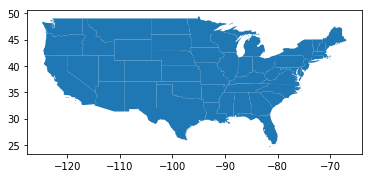

In [17]:
#map graph
map48.plot()

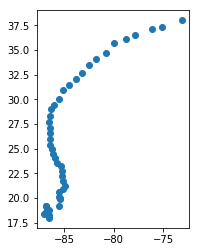

In [18]:
#plot the coordinates (no map)
geo_HR.plot()

Text(0.5, 1.0, 'path of Hurricane Michael onto the US map')

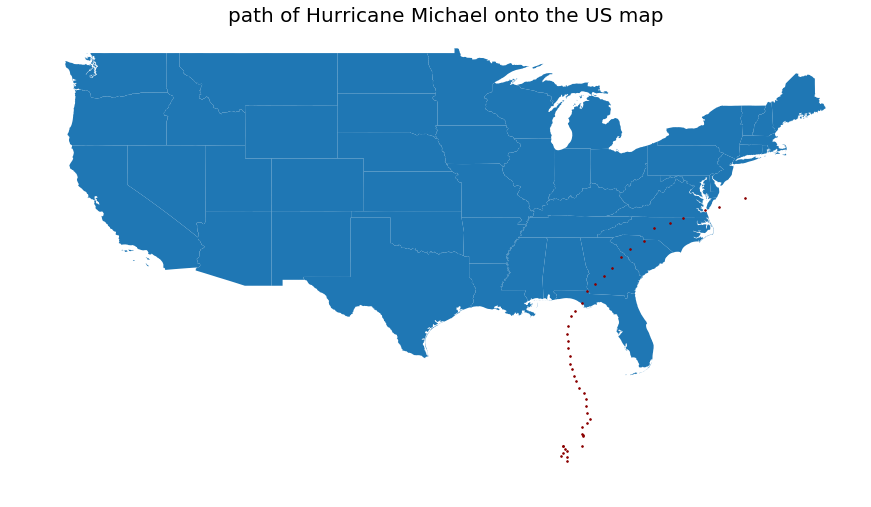

In [44]:
#plot coordinates on top of map graph

#this is to set the size of the borders
fig, ax = plt.subplots(1, figsize=(15,10))

#this is the map
basemap = map48.plot(ax=ax)

#plot coordinates on top of map graph
geo_HR.plot(ax=basemap, color='darkred', marker=".", markersize=10)

#take off axis numbers
ax.axis('off')

#put title on map
ax.set_title("path of Hurricane Michael onto the US map", fontsize=20, fontweight=3)